In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)      # Ignore warnings
warnings.simplefilter(action='ignore', category=UserWarning)        # Ignore warnings
import sys
import numpy as np
import matplotlib.pyplot as plt 
from scipy.interpolate import InterpolatedUnivariateSpline
from IPython.display import Javascript, display, clear_output
import sys
sys.path.append('python/')                # Define path for libraries
import downloadSPARCdata as dsd           # Import library to download data files

## SPARC Activity

In the following activity you will download rotation curve data of different galaxies from the Spitzer Photometry & Accurate Rotation Curves (SPARC) database and plot them with and without a dark matter component to understand how the "missing mass" affects the rotation of stars. <br>
You may either download and unzip the data files yourself or have Python do the work. 

#### Option 1. Download and unzip the data files yourself:
1. Go to http://astroweb.cwru.edu/SPARC/ and under "BASIC SPARK DATA", download the Rotmod_LTG.zip file for "Newtonian Mass Models".
2. Open (extract/unzip) the zip file to preferably the same location as where your Python notebook is located. 
3. Choose a galaxy (any file) of your choice. Do not rename the file. Put the name of the chosen galaxy in the variable in the cell below and run it.
4. Make a note of the directory (file location) of the SPARC file of your galaxy **with respect to this location of this python notebook**. For example, if your file is located in the same location as this code, leave the following cell as is. But if it is, say, in the next folder "up" from this one, use the extension '../'. So an example of if the SPARC file is located two folders then one folder "down" (into a different folder named, say, 'otherfolder'), you would write:
`SPARC_file_directory='../../otherfolder/'` in the cell below and run it.

In [2]:
SPARC_file_directory='data/sparc/'                 #note that '' means the string variable is blank

#### Option 2. Let Python download and unzip the data files
1. By clicking the YES button, you can download and unzip SPARC data files to your computer. 

In [3]:
print("Would you like to download and unzip SPARC data files to your computer?")
dsd.displaybuttons

Would you like to download and unzip SPARC data files to your computer?


## Choose a galaxy

Select any galaxy from the dropdown menu.

In [4]:
galaxylist = ['NGC5005']                 # default list of galaxies  
def on_change(change):                   # add selected galaxynames to the list
    if change['type'] == 'change' and change['name'] == 'value':
        galaxylist.append(change['new'])
        display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
dsd.dropdownmenu.observe(on_change)
display(dsd.galaxyoptions)

Box(children=(Box(children=(Label(value='Galaxy: '), Dropdown(index=79, options=('CamB', 'D512-2', 'D564-8', '…

Once you selected a galaxy, click on the cell below &#8595; &#8595; &#8595; , then select `Run` &#8594; `Run Selected Cell and All Below` to reveal the rotation curve and the image of the chosen galaxy in the following cells. 

In [21]:
# Writing the chosen galaxy name in a text file would allow us to use the selection in libraries outside of this notebook
chosengalaxy = galaxylist[-1]              # define the last element of the list as the selected galaxy
textfile = open("python/chosengalaxy.txt", "w")
textfile.write(chosengalaxy)
textfile.close()
textfile = open("python/chosengalaxy.txt", "r")
textfile.close()

5. The downloaded files are named as "[galaxy name]\_rotmod.dat" so you can define the file path by chosing the relevant file directory + your filename.

In [22]:
# Define file path for .dat files
SPARC_file = SPARC_file_directory + chosengalaxy + '_rotmod.dat'

# Load the galaxy data
galaxydata = np.loadtxt(SPARC_file)

6. Print the header to see what variable each column corresponds to.

In [23]:
# Print header 
for lines in open(SPARC_file, 'r'):
    if lines.startswith('#'):
        print(lines)

# Distance = 4.37 Mpc

# Rad	Vobs	errV	Vgas	Vdisk	Vbul	SBdisk	SBbul		

# kpc	km/s	km/s	km/s	km/s	km/s	L/pc^2	L/pc^2



__Header Key__:<br>
>_Rad_: radius or distance from the center of galaxy (in kiloparsec) <br>
>_Vobs_: observed velocity/measured datapoints (in km/s) <br>
>_errV_: uncertainty in the observed velocity (in km/s) <br>
>_Vgas_: velocity of the gas component (in km/s) <br>
>_Vdisk_: velocity of the disk component (in km/s) <br>
>_Vbul_: velocity of the bulge component (in km/s) <br>
>_SBdisk_: surface brightness of the disk component (in Luminosity/$ \rm parsec^2$) <br>
>_SBbul_: surface brightness of the bulge component (in Luminosity/$ \rm parsec^2$)

7. Split columns into arrays and name them according to the header displayed in the cell above.

In [24]:
# Split columns into arrays
Rad,Vobs,errV,Vgas,Vdisk,Vbul,SBdisk,SBbul = galaxydata.T     

8. The distance to the galaxy is given in the data file in Megaparsecs (1 Mpc equals about 3.26 million light years). You can define this value in your Python notebook for your reference. 

In [25]:
# Define distance in Mpc
firstline = open(SPARC_file).readline()         # Open the data file
firstline = firstline.split()                   # Split the first line into separate strings
distance = float(firstline[3])                  # Take the 4th value of the first line (counts: 0,1,2,3...)
print("The distance to {} galaxy is {} Mpc.".format(chosengalaxy,distance))

The distance to NGC4068 galaxy is 4.37 Mpc.


9. Due to the low number of datapoints, the rotation curve might look choppy. In order to smooth it, you can define a polynomial using Scipy's Interpolated Univariate Spline function, then chose your range and number of datapoints (sampling radii) to define the new, more smooth curve of each component. 

In [26]:
# Spline function
def interpd(x,y):
    return InterpolatedUnivariateSpline(x,y,k=3)      # Degree of the smoothing spline: 3

# Bulge
def bulge(r,bpref):
    polynomial = interpd(Rad,bpref*Vbul)              # bpref is the bulge prefactor added to the bulge
    return polynomial(r)

# Disk
def disk(r,dpref):
    polynomial = interpd(Rad,dpref*Vdisk)             # dpref is the disk prefactor added to the disk
    return polynomial(r)

# Gas 
def gas(r):
    polynomial = interpd(Rad,Vgas)                    # Note that the gas doesn't have a prefactor
    return polynomial(r)

## Observed velocity of the chosen galaxy

10. Let's plot the observed velocity (measured datapoints) and the errorbars on each measurement of the chosen galaxy as a function of radius.

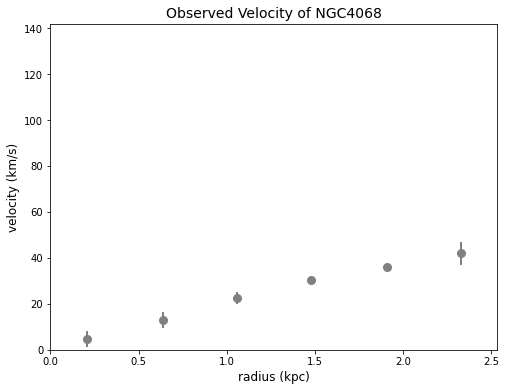

In [27]:
plt.figure(figsize=(8,6))                                                # size of the galaxy
plt.errorbar(Rad,Vobs,yerr=errV, marker='o', markersize=8, \
             ecolor='gray',color='gray', linestyle='none', linewidth=2)  # plot datapoints with errorbars
plt.xlabel('radius (kpc)',size=12)                                       # label x-axis
plt.ylabel('velocity (km/s)',size=12)                                    # label y-axis
plt.title(str('Observed Velocity of ' + chosengalaxy), size=14)          # title of the plot
plt.xlim(0,np.max(Rad)+0.2)                                              # range of the x-axis
plt.ylim(0,np.max(Vobs)+100)                                             # range of the y-axis
plt.show()                                                               # show the plot

11. A prefactor or mass-to-light ratio ($\Upsilon$) is added to the disk and the bulge which will be useful when fitting the curve of each component. These prefactors help scaling the curve up and down. You can either change these values manually and see the magnitude of the relevant curve change in the cells below, or import the fitting parameters from a python library. <br>
        pref_bulge: bulge prefactor
        pref_disk: disk prefactor
    Note that the gas prefactor is missing. The mass of the gas was calculated assuming a factor of 1.33 to account for the contribution of helium. 

In [28]:
import widget_SPARC as fit        # Import widget library for using the fitting parameters
import importlib
importlib.reload(fit)             # Reload widget library so the changes take effect
clear_output()

In [29]:
# Prefactors
pref_bulge = fit.best_bpref
pref_disk = fit.best_dpref

# Radius for plotting
radius = np.linspace(np.min(Rad),np.max(Rad),1000) # starting at the same radius where the given datapoints start, 
                                                   # ending at the same radius where the given datapoints end, 
                                                   # with 1000 datapoints

## Rotational velocity of each luminous component

12. Let's plot the rotation velocity of each component. <br>
    Each component was calculated using the following model: <br>
    >Bulge: residual luminosity profile <br>
    >Disk: observed [3.6] surface brightness profile<br>
    >Gas: HI surface density profiles or mass models

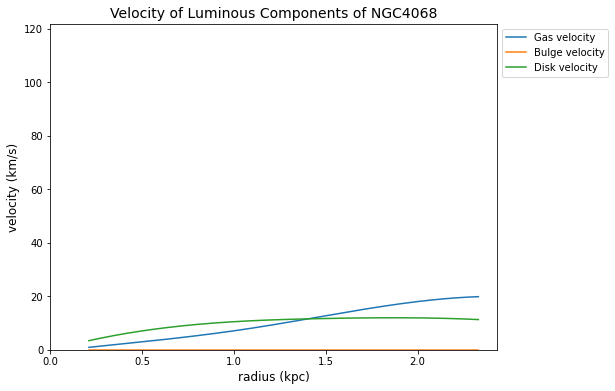

In [30]:
plt.figure(figsize=(8,6))
plt.plot(radius, gas(radius),              label="Gas velocity")
plt.plot(radius, bulge(radius,pref_bulge), label="Bulge velocity")
plt.plot(radius, disk(radius,pref_disk),   label="Disk velocity")
plt.xlabel('radius (kpc)',  size=12)
plt.ylabel('velocity (km/s)', size=12)
plt.title(str('Velocity of Luminous Components of ' + chosengalaxy), size=14)
plt.xlim(0,np.max(Rad + 0.1))
plt.ylim(0,np.max(Vobs + 80))
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

## Total velocity curve of baryonic matter

13. Now that we have all of the luminous components or baryonic matter: bulge, disk and gas, we can add them in quadrature with equivalent prefactors to get the total velocity of the luminous or baryonic matter. 

>__Total velocity of baryonic matter__: <br>
    \begin{equation}
    v_{total,bary}(r) = \sqrt{\lvert v_{gas}\rvert v_{gas} + \Upsilon _{bulge} \lvert v_{bulge}\rvert v_{bulge} + \Upsilon _{disk} \lvert v_{disk}\rvert v_{disk}}
    \end{equation}<br>

In [31]:
def total_velocity_bary(r,pref_bulge,pref_disk):             
    return np.sqrt(gas(r)**2 + bulge(r,pref_bulge)**2 + disk(r,pref_disk)**2)

14. Plot the luminous components and the total velocity.

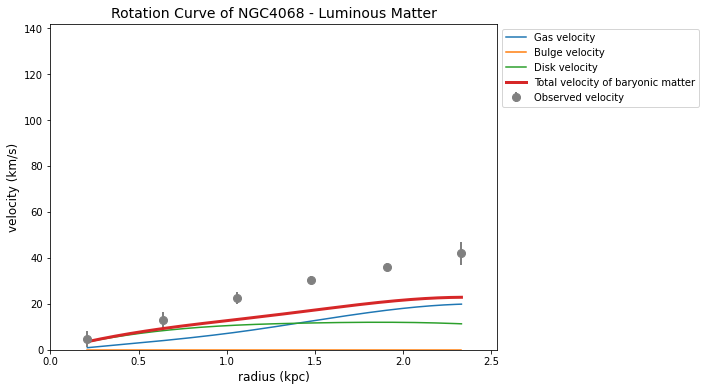

In [32]:
plt.figure(figsize=(8,6))

plt.plot(radius, gas(radius),               label="Gas velocity",   color='#1f77b4')
plt.plot(radius, bulge(radius,pref_bulge),  label="Bulge velocity", color='#ff7f0e')
plt.plot(radius, disk(radius,pref_disk),    label="Disk velocity",  color='#2ca02c')

plt.plot(radius,total_velocity_bary(radius,pref_bulge,pref_disk), label="Total velocity of baryonic matter", color='#d62728', linewidth=3)
plt.errorbar(Rad,Vobs,yerr=errV, marker='o', markersize=8, \
             ecolor='gray',color='gray', linestyle='none', linewidth=2, label = "Observed velocity")
plt.xlabel('radius (kpc)',size=12)
plt.ylabel('velocity (km/s)',size=12)
plt.title(str('Rotation Curve of ' + chosengalaxy + ' - Luminous Matter'), size=14)
plt.xlim(0,np.max(Rad + 0.2))
plt.ylim(0,np.max(Vobs) + 100)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

15. Notice that the total velocity does not align with the measured velocity. Not even if you scale the other components up and down with the prefactor. Let's add the "missing matter".

## Add dark matter

16. Dark matter can be characterized by two parameters: the central mass density and the core radius. <br>
***Central mass density***: The central mass density is the density at the center of the galaxy, changing this value changes the magnitude of the dark matter curve. <br>
***Core radius***: The core radius (also called "cutoff radius" or "scale radius") indicates where the density falls off by a factor of e (~2.7). Adjusting this factor changes where the "bump" of the curve is located.

>__Velocity__: <br>
    \begin{equation}
    v_{DM}(r) = \sqrt{4 \pi G \rho_{0} r_c^2 \big( 1- \frac{r_c}{r} \arctan{\frac{r}{r_c}}\big)}
    \end{equation}<br>
    
   >where:<br>
        $G$ = gravitational constant<br>
        $\rho_0$ = central mass density (in solar mass/$\rm kpc^3$)<br>
        $r_c$ = core radius (in kpc)<br>

17. Set parameters or import the fitting parameters from a Python library. The fitting parameters were calculated using the Python library: lmfit. 

In [33]:
# Dark matter halo parameters
rho0 = fit.best_rho0     # Central mass density (in solar mass/kpc^3)
rc = fit.best_rc         # Core radius (in kpc)

# Constant parameters
G = 4.300e-6             # Gravitational constant (kpc/solar mass*(km/s)^2)

# Print values
print("The fitted best values for the {} galaxy: ".format(chosengalaxy))
print("    Central mass density of the dark matter halo = {:.3e} solar mass/kpc^3".format(rho0))
print("    Core radius of the dark matter halo = {:.3f} kpc".format(rc))

The fitted best values for the NGC4068 galaxy: 
    Central mass density of the dark matter halo = 1.830e+07 solar mass/kpc^3
    Core radius of the dark matter halo = 2.415 kpc


In [34]:
# Equation for dark matter halo velocity
def halo(r,rho0,rc):
    v = np.sqrt(4*np.pi*G*rho0*rc**2*(1 - rc/r * np.arctan(r/rc)))
    return v

18. Now, calculate the total velocity with the dark matter component included. 

In [35]:
def total_velocity_withDM(r,pref_bulge,pref_disk,rho0,rc):             
    return np.sqrt(gas(r)**2 + bulge(r,pref_bulge)**2 + disk(r,pref_disk)**2 + halo(r,rho0,rc)**2)

19. Plot all components and the total velocity with the dark matter.

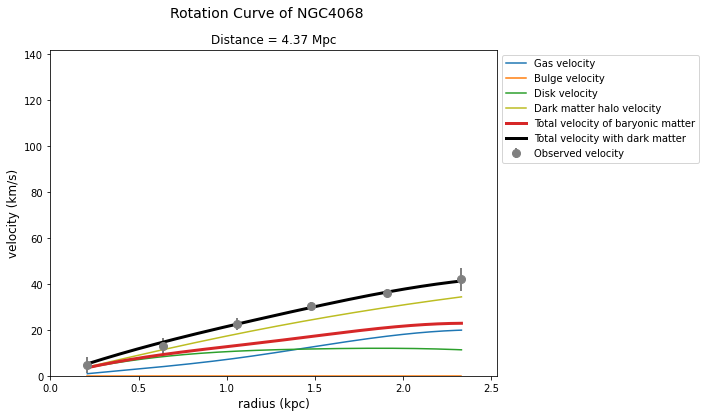

In [36]:
plt.figure(figsize=(8,6))

plt.plot(radius, gas(radius),              label="Gas velocity",   color='#1f77b4')
plt.plot(radius, bulge(radius,pref_bulge), label="Bulge velocity", color='#ff7f0e')
plt.plot(radius, disk(radius,pref_disk),   label="Disk velocity",  color='#2ca02c')
plt.plot(radius, halo(radius,rho0,rc),     label="Dark matter halo velocity",  color='#bcbd22')

plt.plot(radius,total_velocity_bary(radius,pref_bulge,pref_disk), label="Total velocity of baryonic matter", color='#d62728', linewidth=3)
plt.plot(radius,total_velocity_withDM(radius,pref_bulge,pref_disk,rho0,rc), label="Total velocity with dark matter", color='k', linewidth=3)

plt.errorbar(Rad,Vobs,yerr=errV, marker='o', markersize=8, \
             ecolor='gray',color='gray', linestyle='none', linewidth=2, label = "Observed velocity")
plt.xlabel('radius (kpc)',size=12)
plt.ylabel('velocity (km/s)',size=12)
plt.suptitle(str('Rotation Curve of ' + chosengalaxy), size=14)
plt.title(str('Distance = {} Mpc'.format(distance)), size=12)
plt.xlim(0,np.max(Rad + 0.2))
plt.ylim(0,np.max(Vobs) + 100)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

# References <br>
>Jimenez, Raul, Licia Verde, and S. Peng Oh. __"Dark halo properties from rotation curves."__ _Monthly Notices of the Royal Astronomical Society_ 339, no. 1 (2003): 243-259. https://doi.org/10.1046/j.1365-8711.2003.06165.x. <br><br>
>Lelli, Federico, Stacy S. McGaugh, and James M. Schombert. __“SPARC: Mass Models for 175 Disk Galaxies with Spitzer Photometry and Accurate Rotation Curves.”__ _The Astronomical Journal 152_, no. 6 (2016): 157. https://doi.org/10.3847/0004-6256/152/6/157. <br><br>
>Matt Newville, Renee Otten, Andrew Nelson, Antonino Ingargiola, Till Stensitzki, Dan Allan, Austin Fox, Faustin Carter, Michał, Ray Osborn, Dima Pustakhod, lneuhaus, Sebastian Weigand, Glenn, Christoph Deil, Mark, Allan L. R. Hansen, Gustavo Pasquevich, Leon Foks, … Arun Persaud. (2021). __"lmfit/lmfit-py: 1.0.3 (1.0.3)."__ Zenodo. https://doi.org/10.5281/zenodo.5570790. <br><br>
>“Megaparsec: Cosmos.” __Megaparsec__ | _COSMOS_. Swinburne University of Technology. Accessed November 12, 2021. https://astronomy.swin.edu.au/cosmos/m/megaparsec. 
***